# Collaborative Filtering for Item Recommendations

## Introduction

The ratings dataset lists the ratings given by a set of users to a set of items.
Our goal is to be able to predict ratings for items a user has not yet got.
The items with the highest predicted ratings can then be recommended to the user.

The steps in the model are as follows:

1. Map user ID to a "user vector" via an embedding matrix
2. Map item ID to a "item vector" via an embedding matrix
3. Compute the dot product between the user vector and item vector, to obtain
the a match score between the user and the item (predicted rating).
4. Train the embeddings via gradient descent using all known user-item pairs.

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from pathlib import Path
import matplotlib.pyplot as plt

## First, load the data and apply preprocessing

In [ ]:
df = pd.read_csv("train.csv")

In [ ]:
df=df[:500000]

First, need to perform some preprocessing to encode users and items as integer indices.

In [ ]:
user_ids = df["userId"].unique().tolist()
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
userencoded2user = {i: x for i, x in enumerate(user_ids)}
item_ids = df["itemId"].unique().tolist()
item2item_encoded = {x: i for i, x in enumerate(item_ids)}
item_encoded2item = {i: x for i, x in enumerate(item_ids)}
df["user"] = df["userId"].map(user2user_encoded)
df["item"] = df["itemId"].map(item2item_encoded)

num_users = len(user2user_encoded)
num_items = len(item_encoded2item)
df["rating"] = df["rating"].values.astype(np.float32)
# min and max ratings will be used to normalize the ratings later
min_rating = min(df["rating"])
max_rating = max(df["rating"])

print(
    "Number of users: {}, Number of Items: {}, Min rating: {}, Max rating: {}".format(
        num_users, num_items, min_rating, max_rating
    )
)

Number of users: 3289, Number of Items: 20109, Min rating: 1.0, Max rating: 5.0


## Prepare training and validation data

In [ ]:
df = df.sample(frac=1, random_state=42)
x = df[["user", "item"]].values
# Normalize the targets between 0 and 1. Makes it easy to train.
y = df["rating"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values
# Assuming training on 90% of the data and validating on 10%.
train_indices = int(0.9 * df.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:],
)

## Create the model

We embed both users and items in to 50-dimensional vectors.

The model computes a match score between user and item embeddings via a dot product,
and adds a per-item and per-user bias. The match score is scaled to the `[0, 1]`
interval via a sigmoid (since our ratings are normalized to this range).

In [ ]:
EMBEDDING_SIZE = 50


class RecommenderNet(keras.Model):
    def __init__(self, num_users, num_items, embedding_size, **kwargs):
        super().__init__(**kwargs)
        self.num_users = num_users
        self.num_items = num_items
        self.embedding_size = embedding_size
        self.user_embedding = layers.Embedding(
            num_users,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.user_bias = layers.Embedding(num_users, 1)
        self.item_embedding = layers.Embedding(
            num_items,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.item_bias = layers.Embedding(num_items, 1)

    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        item_vector = self.item_embedding(inputs[:, 1])
        item_bias = self.item_bias(inputs[:, 1])
        dot_user_item = tf.tensordot(user_vector, item_vector, 2)
        # Add all the components (including bias)
        x = dot_user_item + user_bias + item_bias
        # The sigmoid activation forces the rating to between 0 and 1
        return tf.nn.sigmoid(x)


model = RecommenderNet(num_users, num_items, EMBEDDING_SIZE)
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
)

## Train the model based on the data split

In [ ]:
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=64,
    epochs=5,
    verbose=1,
    validation_data=(x_val, y_val),
)

Epoch 1/5
7032/7032 [==============================] - 133s 19ms/step - loss: 0.6521 - val_loss: 0.6453
Epoch 2/5
7032/7032 [==============================] - 132s 19ms/step - loss: 0.6498 - val_loss: 0.6515
Epoch 3/5
7032/7032 [==============================] - 134s 19ms/step - loss: 0.6596 - val_loss: 0.6622
Epoch 4/5
7032/7032 [==============================] - 132s 19ms/step - loss: 0.6724 - val_loss: 0.6696
Epoch 5/5
7032/7032 [==============================] - 131s 19ms/step - loss: 0.6838 - val_loss: 0.6780


## Plot training and validation loss

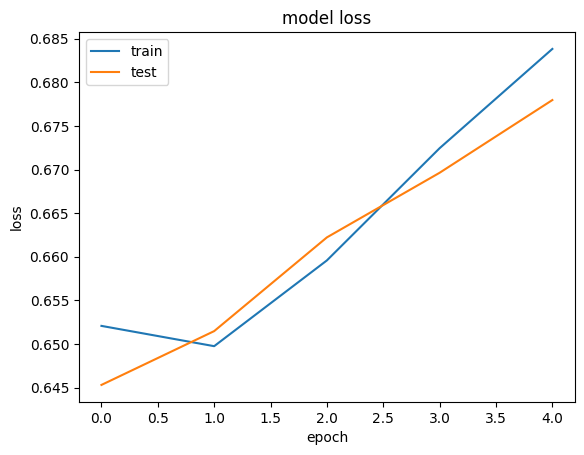

In [ ]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()